In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora/sample_submission.csv
/kaggle/input/quora/train.csv
/kaggle/input/quora/test.csv


In [2]:
!pip install gensim
!pip install emot
!pip install emojis
!pip install pandarallel
!pip install contractions

  Created wheel for pandarallel: filename=pandarallel-1.5.1-py3-none-any.whl size=17127 sha256=ee868f319a6d12ac44567d62c5a68ad95e76f6bdb1905e430077dfe82cb81f37
  Stored in directory: /root/.cache/pip/wheels/bd/da/5f/2e65e230a994adb965df002373975e66b3bd1cb90c0706b9ac
Successfully built pandarallel
     |████████████████████████████████| 312 kB 909 kB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp37-cp37m-linux_x86_64.whl size=99066 sha256=ce884122afedf28b73f1f6b5320d148326565506b41a04896988c49d61d24361
  Stored in directory: /root/.cache/pip/wheels/9b/6b/f7/62dc8caf183b125107209c014e78c340a0b4b7b392c23c2db4
Successfully built pyahocorasick


In [3]:
import os
import json
import string
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

import nltk
import operator 
import re
import gc
import keras
import gensim

from nltk import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from tqdm import tqdm
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# Loading the test data

qiq_tst = pd.read_csv("/kaggle/input/quora/test.csv")
print("Number of texts: ", qiq_tst.shape[0])

Number of texts:  522449


Text processing - TEST DATASET

In [5]:
df_tst = pd.DataFrame(qiq_tst["qid"])

In [6]:
# lowercasing the words

def lowerCase(text):
    lower_case = text.lower()
    return lower_case

df_tst["lowercase"] = qiq_tst["question_text"].apply(lambda text: lowerCase(text))

In [7]:
# Removing html tags

def rmvHtmlTags(text):
    html_pattern = r'<.*?>'
    no_html = re.sub(pattern=html_pattern, repl=' ', string=text)
    return no_html

df_tst["nohtmltags"] = df_tst["lowercase"].apply(lambda text: rmvHtmlTags(text)) 

In [8]:
def rmvUrls(text):
    url_pattern = r'https?://\S+|www\.\S+'
    nourl = re.sub(pattern=url_pattern, repl=' ', string=text)
    return nourl

df_tst["nourls"] = df_tst["nohtmltags"].apply(lambda text: rmvUrls(text))


In [9]:
# Removing numbers

def rmvNums (text):
    num_pattern = r'\d+'
    no_num = re.sub(pattern=num_pattern, repl = ' ', string=text)
    return no_num
    
df_tst["nonumbers"] = df_tst["nourls"].apply(lambda text: rmvNums(text))  

In [10]:
# Expand contractions

import contractions

df_tst['nocontraction'] = df_tst['nonumbers'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df_tst['nocontract'] = df_tst['nocontraction'].apply(lambda x: " ".join(x))



In [11]:
# Removing of Punctuations or Special Characters

from string import punctuation

def rmvPunctuation(text):
    no_punct = text.translate(str.maketrans('', '', punctuation))
    return no_punct

df_tst["nopunct"] = df_tst["nocontract"].apply(lambda text: rmvPunctuation(text)) 

In [12]:
# Removing special characters

def rmvSplChars(text):
    alphanumeric = [character for character in text if character.isalnum()]
    text = "".join(alphanumeric)
    return text

df_tst["no_splchars"] = df_tst["nopunct"].apply(lambda text: rmvPunctuation(text))

In [13]:
df_tst.head(5)

,qid,lowercase,nohtmltags,nourls,nonumbers,nocontraction,nocontract,nopunct,no_splchars
0,f56a9a31974dc66186e8,is it a good idea to go through a phlebotomy c...,is it a good idea to go through a phlebotomy c...,is it a good idea to go through a phlebotomy c...,is it a good idea to go through a phlebotomy c...,"[is, it, a, good, idea, to, go, through, a, ph...",is it a good idea to go through a phlebotomy c...,is it a good idea to go through a phlebotomy c...,is it a good idea to go through a phlebotomy c...
1,d957c3758060f45da303,how can i fix a lead into a camlin compass to ...,how can i fix a lead into a camlin compass to ...,how can i fix a lead into a camlin compass to ...,how can i fix a lead into a camlin compass to ...,"[how, can, i, fix, a, lead, into, a, camlin, c...",how can i fix a lead into a camlin compass to ...,how can i fix a lead into a camlin compass to ...,how can i fix a lead into a camlin compass to ...
2,ad822d5abaedb9e247b9,how many animes are there in world?,how many animes are there in world?,how many animes are there in world?,how many animes are there in world?,"[how, many, animes, are, there, in, world?]",how many animes are there in world?,how many animes are there in world,how many animes are there in world
3,4e979c23eeb6a4bd1f2e,how do i tell my family i cut?,how do i tell my family i cut?,how do i tell my family i cut?,how do i tell my family i cut?,"[how, do, i, tell, my, family, i, cut?]",how do i tell my family i cut?,how do i tell my family i cut,how do i tell my family i cut
4,333cc031262566b8da49,how do i save down my bitcoin image address fr...,how do i save down my bitcoin image address fr...,how do i save down my bitcoin image address fr...,how do i save down my bitcoin image address fr...,"[how, do, i, save, down, my, bitcoin, image, a...",how do i save down my bitcoin image address fr...,how do i save down my bitcoin image address fr...,how do i save down my bitcoin image address fr...


In [14]:
# Convert accented characters to ASCII characters

import unidecode

def accented_to_ascii(text):
    text = unidecode.unidecode(text)
    return text

df_tst["noaccented"] = df_tst["no_splchars"].apply(lambda text: accented_to_ascii(text)) 

In [15]:
# Removing single characters

def rmvSincgleChars (text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

df_tst["nosinglechars"] = df_tst["noaccented"].apply(lambda text: rmvSincgleChars(text)) 

In [16]:
# Implementation  of removing extra whitespaces

def rmvExtraSpaces(text):
    space_pattern = r'\s+'
    without_space = re.sub(pattern=space_pattern, repl=" ", string=text)
    return without_space

df_tst["nospaces"] = df_tst["nosinglechars"].apply(lambda text: rmvExtraSpaces(text)) 

In [17]:
# Removing stop words
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

STOPWORDS = set(stopwords.words('english'))
def rmvStopwords(text):
    text = " ".join([word for word in str(text).split() if word not in STOPWORDS])
    return text

df_tst["nostopwords"] = df_tst["nospaces"].apply(lambda text: rmvStopwords(text)) 

In [18]:
# Saving the text processed file

df_tst.to_csv('TextProcessed_TestSet.csv',index=False)

# ADVANCED TEXT PROCESSING WITH STOPWORDS

In [19]:
df_tst_adv = pd.DataFrame()

df_tst_adv = df_tst[["qid", "nospaces", "nostopwords"]]

In [20]:
df_tst_adv.head()

,qid,nospaces,nostopwords
0,f56a9a31974dc66186e8,is it good idea to go through phlebotomy class...,good idea go phlebotomy class going nursing sc...
1,d957c3758060f45da303,how can fix lead into camlin compass to draw a...,fix lead camlin compass draw arcs circles engi...
2,ad822d5abaedb9e247b9,how many animes are there in world,many animes world
3,4e979c23eeb6a4bd1f2e,how do tell my family cut,tell family cut
4,333cc031262566b8da49,how do save down my bitcoin image address from...,save bitcoin image address coinbase


TOKENIZATION

In [21]:
def tokenize(txt):
    tokens = re.split('\W+', txt)
    return tokens


df_tst_adv['Tokenized_text'] = df_tst_adv['nospaces'].apply(lambda x: tokenize(x.lower()))

df_tst_adv.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,qid,nospaces,nostopwords,Tokenized_text
0,f56a9a31974dc66186e8,is it good idea to go through phlebotomy class...,good idea go phlebotomy class going nursing sc...,"[is, it, good, idea, to, go, through, phleboto..."
1,d957c3758060f45da303,how can fix lead into camlin compass to draw a...,fix lead camlin compass draw arcs circles engi...,"[how, can, fix, lead, into, camlin, compass, t..."
2,ad822d5abaedb9e247b9,how many animes are there in world,many animes world,"[how, many, animes, are, there, in, world]"
3,4e979c23eeb6a4bd1f2e,how do tell my family cut,tell family cut,"[how, do, tell, my, family, cut]"
4,333cc031262566b8da49,how do save down my bitcoin image address from...,save bitcoin image address coinbase,"[how, do, save, down, my, bitcoin, image, addr..."


LEMMATIZATION

In [22]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

wordnet=WordNetLemmatizer()
ps=PorterStemmer()

def lemmatization(tokens):
    text = [wordnet.lemmatize(word) for word in tokens]
    return text

df_tst_adv['lemm_text'] = df_tst_adv['Tokenized_text'].apply(lambda x : lemmatization(x))
df_tst_adv.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,qid,nospaces,nostopwords,Tokenized_text,lemm_text
0,f56a9a31974dc66186e8,is it good idea to go through phlebotomy class...,good idea go phlebotomy class going nursing sc...,"[is, it, good, idea, to, go, through, phleboto...","[is, it, good, idea, to, go, through, phleboto..."
1,d957c3758060f45da303,how can fix lead into camlin compass to draw a...,fix lead camlin compass draw arcs circles engi...,"[how, can, fix, lead, into, camlin, compass, t...","[how, can, fix, lead, into, camlin, compass, t..."
2,ad822d5abaedb9e247b9,how many animes are there in world,many animes world,"[how, many, animes, are, there, in, world]","[how, many, anime, are, there, in, world]"
3,4e979c23eeb6a4bd1f2e,how do tell my family cut,tell family cut,"[how, do, tell, my, family, cut]","[how, do, tell, my, family, cut]"
4,333cc031262566b8da49,how do save down my bitcoin image address from...,save bitcoin image address coinbase,"[how, do, save, down, my, bitcoin, image, addr...","[how, do, save, down, my, bitcoin, image, addr..."


VECTORIZATION

In [23]:
#Converting List to strings

# Function to convert   
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 


df_tst_adv['lemm_str'] = df_tst_adv['lemm_text'].apply(lambda x: listToString(x))

df_tst_adv.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,qid,nospaces,nostopwords,Tokenized_text,lemm_text,lemm_str
0,f56a9a31974dc66186e8,is it good idea to go through phlebotomy class...,good idea go phlebotomy class going nursing sc...,"[is, it, good, idea, to, go, through, phleboto...","[is, it, good, idea, to, go, through, phleboto...",is it good idea to go through phlebotomy class...
1,d957c3758060f45da303,how can fix lead into camlin compass to draw a...,fix lead camlin compass draw arcs circles engi...,"[how, can, fix, lead, into, camlin, compass, t...","[how, can, fix, lead, into, camlin, compass, t...",how can fix lead into camlin compass to draw a...
2,ad822d5abaedb9e247b9,how many animes are there in world,many animes world,"[how, many, animes, are, there, in, world]","[how, many, anime, are, there, in, world]",how many anime are there in world
3,4e979c23eeb6a4bd1f2e,how do tell my family cut,tell family cut,"[how, do, tell, my, family, cut]","[how, do, tell, my, family, cut]",how do tell my family cut
4,333cc031262566b8da49,how do save down my bitcoin image address from...,save bitcoin image address coinbase,"[how, do, save, down, my, bitcoin, image, addr...","[how, do, save, down, my, bitcoin, image, addr...",how do save down my bitcoin image address from...


In [24]:
df_tst_adv.to_csv('QIQC_TextProcessed_TestSet.csv',index=False)

# WORD CLOUD

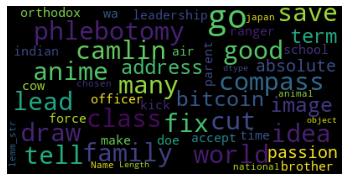

In [25]:
# Wordcloud for entire text in the dataset irrespective of classification as sincere or insincere

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus.reader import WordListCorpusReader 

wordcloud = WordCloud(background_color='black',stopwords=stop_words, max_words=200, max_font_size=40, random_state=42).generate(str(df_tst_adv['lemm_str']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("df_adv_lemm_str.png", dpi=300)

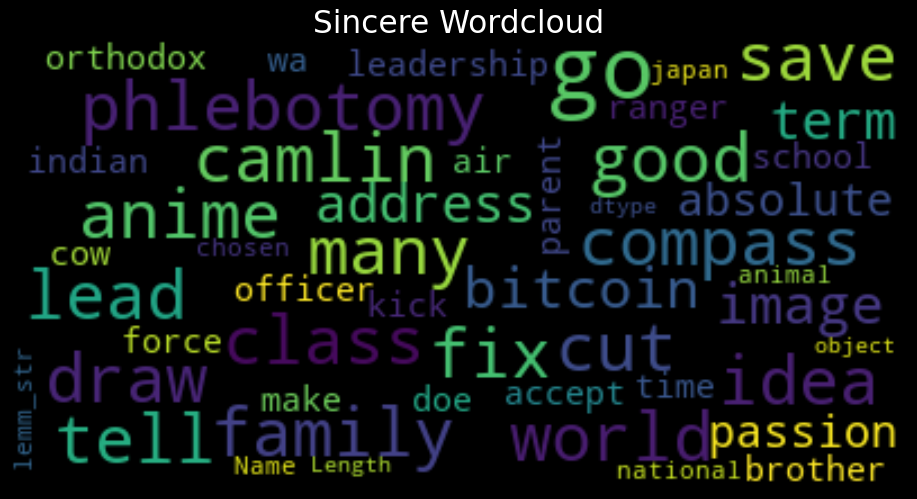

In [26]:
# Wordcloud for entire text in the dataset irrespective of classification as sincere or insincere

wordcloud = WordCloud(background_color='black',stopwords=stop_words, max_words=200, max_font_size=40, random_state=42).generate(str(df_tst_adv['lemm_str']))

print(wordcloud)
fig = plt.figure(figsize=(10,7), dpi=90, facecolor='k',edgecolor='k')
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Sincere Wordcloud", fontsize=25,color='w')
plt.tight_layout(pad=0)
plt.show()
fig.savefig("df_adv_Sincere.png", dpi=300)

# ADVANCED TEXT PROCESSING WITHOUT STOPWORDS

TOKENIZATION

In [27]:
def tokenize(txt):
    tokens = re.split('\W+', txt)
    return tokens


df_tst_adv['nostopwords_Tokenized_text'] = df_tst_adv['nostopwords'].apply(lambda x: tokenize(x.lower()))

df_tst_adv.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,qid,nospaces,nostopwords,Tokenized_text,lemm_text,lemm_str,nostopwords_Tokenized_text
0,f56a9a31974dc66186e8,is it good idea to go through phlebotomy class...,good idea go phlebotomy class going nursing sc...,"[is, it, good, idea, to, go, through, phleboto...","[is, it, good, idea, to, go, through, phleboto...",is it good idea to go through phlebotomy class...,"[good, idea, go, phlebotomy, class, going, nur..."
1,d957c3758060f45da303,how can fix lead into camlin compass to draw a...,fix lead camlin compass draw arcs circles engi...,"[how, can, fix, lead, into, camlin, compass, t...","[how, can, fix, lead, into, camlin, compass, t...",how can fix lead into camlin compass to draw a...,"[fix, lead, camlin, compass, draw, arcs, circl..."
2,ad822d5abaedb9e247b9,how many animes are there in world,many animes world,"[how, many, animes, are, there, in, world]","[how, many, anime, are, there, in, world]",how many anime are there in world,"[many, animes, world]"
3,4e979c23eeb6a4bd1f2e,how do tell my family cut,tell family cut,"[how, do, tell, my, family, cut]","[how, do, tell, my, family, cut]",how do tell my family cut,"[tell, family, cut]"
4,333cc031262566b8da49,how do save down my bitcoin image address from...,save bitcoin image address coinbase,"[how, do, save, down, my, bitcoin, image, addr...","[how, do, save, down, my, bitcoin, image, addr...",how do save down my bitcoin image address from...,"[save, bitcoin, image, address, coinbase]"


LEMMATIZATION

In [28]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

wordnet=WordNetLemmatizer()
ps=PorterStemmer()

def lemmatization(tokens):
    text = [wordnet.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    return text

df_tst_adv['nostopwords_lemm_text'] = df_tst_adv['nostopwords_Tokenized_text'].apply(lambda x : lemmatization(x))
df_tst_adv.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,qid,nospaces,nostopwords,Tokenized_text,lemm_text,lemm_str,nostopwords_Tokenized_text,nostopwords_lemm_text
0,f56a9a31974dc66186e8,is it good idea to go through phlebotomy class...,good idea go phlebotomy class going nursing sc...,"[is, it, good, idea, to, go, through, phleboto...","[is, it, good, idea, to, go, through, phleboto...",is it good idea to go through phlebotomy class...,"[good, idea, go, phlebotomy, class, going, nur...","[good, idea, go, phlebotomy, class, going, nur..."
1,d957c3758060f45da303,how can fix lead into camlin compass to draw a...,fix lead camlin compass draw arcs circles engi...,"[how, can, fix, lead, into, camlin, compass, t...","[how, can, fix, lead, into, camlin, compass, t...",how can fix lead into camlin compass to draw a...,"[fix, lead, camlin, compass, draw, arcs, circl...","[fix, lead, camlin, compass, draw, arc, circle..."
2,ad822d5abaedb9e247b9,how many animes are there in world,many animes world,"[how, many, animes, are, there, in, world]","[how, many, anime, are, there, in, world]",how many anime are there in world,"[many, animes, world]","[many, anime, world]"
3,4e979c23eeb6a4bd1f2e,how do tell my family cut,tell family cut,"[how, do, tell, my, family, cut]","[how, do, tell, my, family, cut]",how do tell my family cut,"[tell, family, cut]","[tell, family, cut]"
4,333cc031262566b8da49,how do save down my bitcoin image address from...,save bitcoin image address coinbase,"[how, do, save, down, my, bitcoin, image, addr...","[how, do, save, down, my, bitcoin, image, addr...",how do save down my bitcoin image address from...,"[save, bitcoin, image, address, coinbase]","[save, bitcoin, image, address, coinbase]"


VECTORIZATION

In [29]:
#Converting List to strings

# Function to convert   
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 


df_tst_adv['nostopwords_lemm_str'] = df_tst_adv['nostopwords_lemm_text'].apply(lambda x: listToString(x))

df_tst_adv.head(5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,qid,nospaces,nostopwords,Tokenized_text,lemm_text,lemm_str,nostopwords_Tokenized_text,nostopwords_lemm_text,nostopwords_lemm_str
0,f56a9a31974dc66186e8,is it good idea to go through phlebotomy class...,good idea go phlebotomy class going nursing sc...,"[is, it, good, idea, to, go, through, phleboto...","[is, it, good, idea, to, go, through, phleboto...",is it good idea to go through phlebotomy class...,"[good, idea, go, phlebotomy, class, going, nur...","[good, idea, go, phlebotomy, class, going, nur...",good idea go phlebotomy class going nursing sc...
1,d957c3758060f45da303,how can fix lead into camlin compass to draw a...,fix lead camlin compass draw arcs circles engi...,"[how, can, fix, lead, into, camlin, compass, t...","[how, can, fix, lead, into, camlin, compass, t...",how can fix lead into camlin compass to draw a...,"[fix, lead, camlin, compass, draw, arcs, circl...","[fix, lead, camlin, compass, draw, arc, circle...",fix lead camlin compass draw arc circle engine...
2,ad822d5abaedb9e247b9,how many animes are there in world,many animes world,"[how, many, animes, are, there, in, world]","[how, many, anime, are, there, in, world]",how many anime are there in world,"[many, animes, world]","[many, anime, world]",many anime world
3,4e979c23eeb6a4bd1f2e,how do tell my family cut,tell family cut,"[how, do, tell, my, family, cut]","[how, do, tell, my, family, cut]",how do tell my family cut,"[tell, family, cut]","[tell, family, cut]",tell family cut
4,333cc031262566b8da49,how do save down my bitcoin image address from...,save bitcoin image address coinbase,"[how, do, save, down, my, bitcoin, image, addr...","[how, do, save, down, my, bitcoin, image, addr...",how do save down my bitcoin image address from...,"[save, bitcoin, image, address, coinbase]","[save, bitcoin, image, address, coinbase]",save bitcoin image address coinbase


In [30]:
df_tst_adv.to_csv('QIQC_TextProcessed_TestSet.csv',index=False)